# Laplacian Associative Memory (LAM) - DEV 13

[Multiscale representations of community structures in attractor neural networks](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8412329/pdf/pcbi.1009296.pdf) (2021)

- Re-run sigma testing protocol with radius updated SOAM

In [1]:
from nn import LAM
import libtools

In [2]:
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# np.random.seed(123)

---

### Gaussian Distribution

In [4]:
rad = 5
sigmaX = 2.0
sigmaY = 0.5

In [5]:
dist = np.linspace(0, rad, 100)
spatial_gaussian = libtools.gaussian(dist, sigmaX)
angular_gaussian = libtools.gaussian(dist, sigmaY)

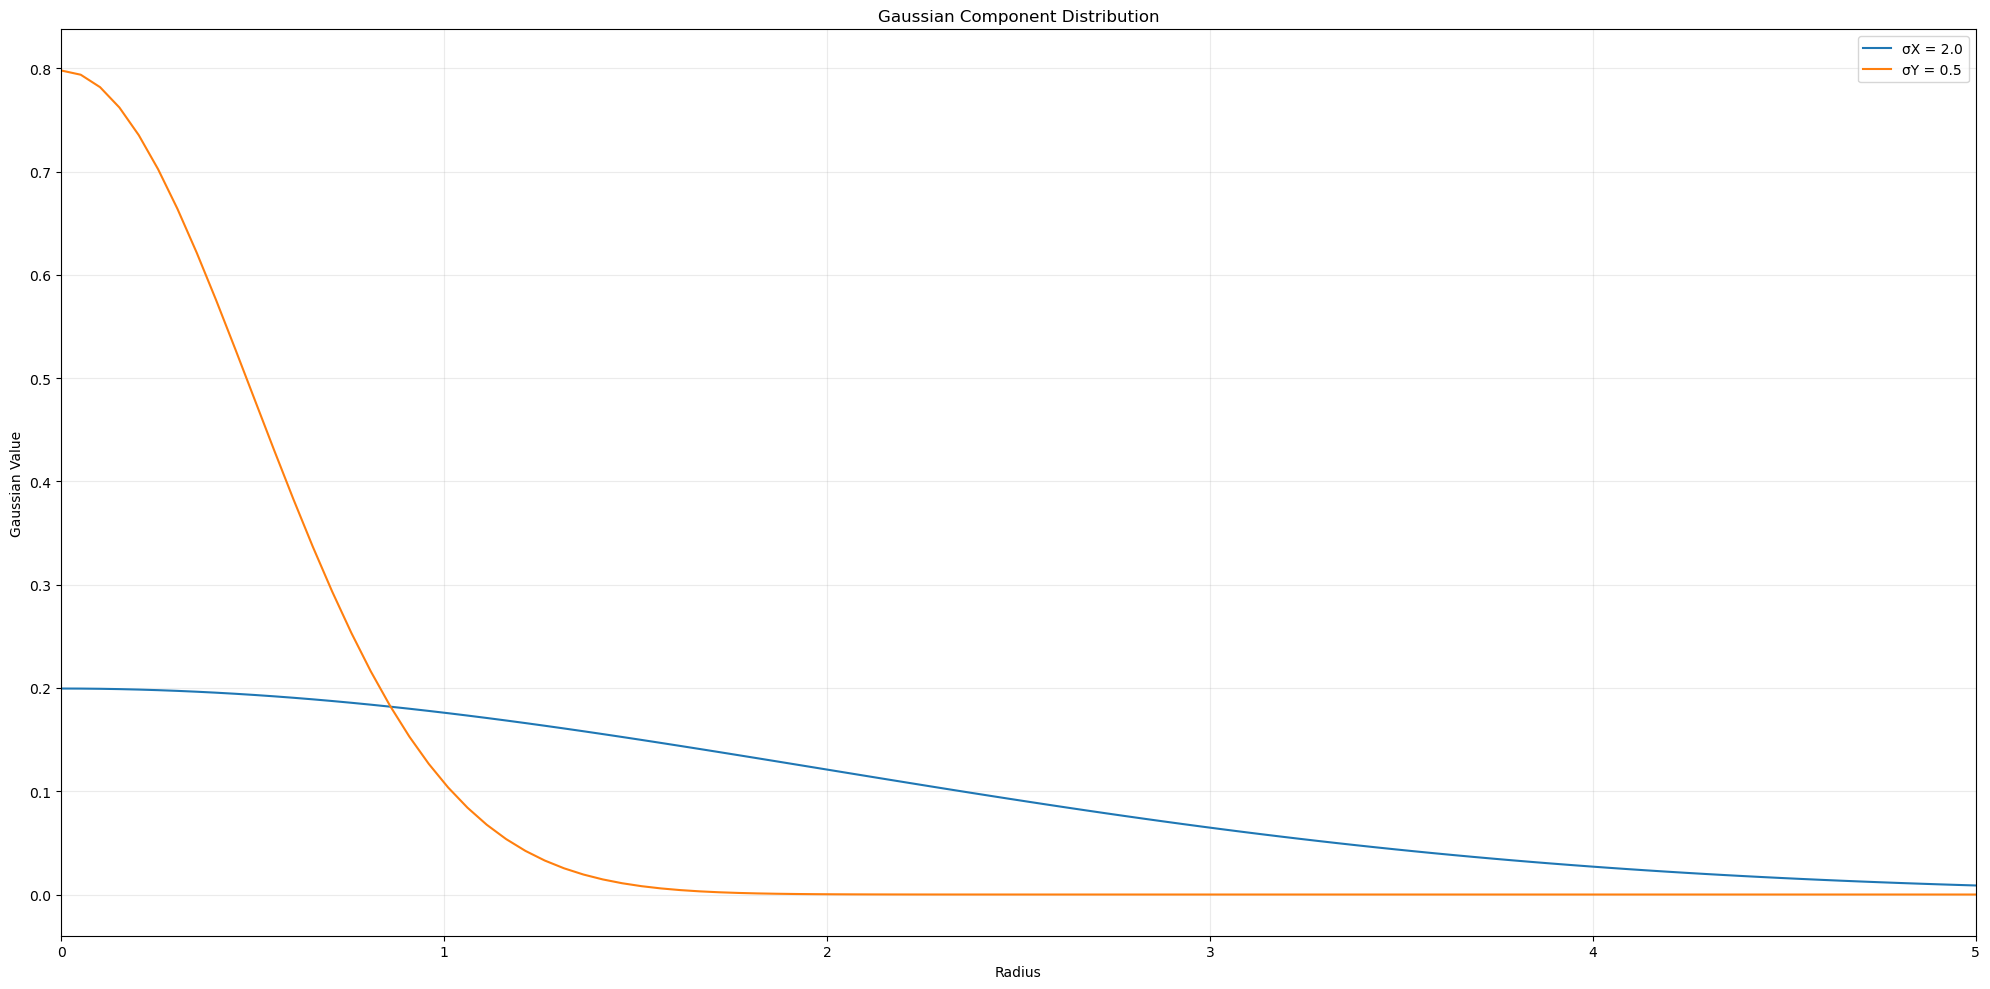

In [6]:
plt.figure(figsize=(20, 10))
plt.plot(dist, spatial_gaussian, label=f'σX = {sigmaX}')
plt.plot(dist, angular_gaussian, label=f'σY = {sigmaY}')
plt.title('Gaussian Component Distribution')
plt.xlabel('Radius'), plt.ylabel('Gaussian Value')
plt.xlim([0, rad]), plt.grid(alpha=0.25), plt.legend()
plt.tight_layout()

---

### Hyper-parameters

In [7]:
N = 4096                                                         # Neurons | Default: 30000
prob = 0.1                                                       # Sparsity
eta = 0.01                                                       # Epsilon / Learning rate
epochs = 3000                                                    # Steps
gamma = 0.6                                                      # Inhibition ratio
norm_mode = 'asym'                                               # Asymmetric Normalisation

---

### LAM

In [8]:
FILENAME = "../data/images/kingfisher_resized.png"

src = PIL.Image.open(FILENAME)
src = np.array(src, dtype=float) / np.max(src)

In [9]:
P = src.shape[0] * src.shape[1]
start_node = int(int(src.shape[0]/2) * src.shape[1] + int(src.shape[0]/2))
print('Start node:', start_node)

Start node: 612


In [10]:
sigmaX = 4.0
sigmaI = 0.1

W = libtools.construct_LAM(src, rad, sigmaX, sigmaI)

_, v = libtools.GL_eigen(W, 'asym')

graph = LAM(N, P, prob, W, gamma, "asym")
alpha = -0.9; graph._set_weight(alpha)
m_log, obj_log = graph.simulate_single(alpha, eta, epochs, start_node)
m = m_log[-1,:]

Text(0.5, 1.0, 'LAM | alpha=-0.9')

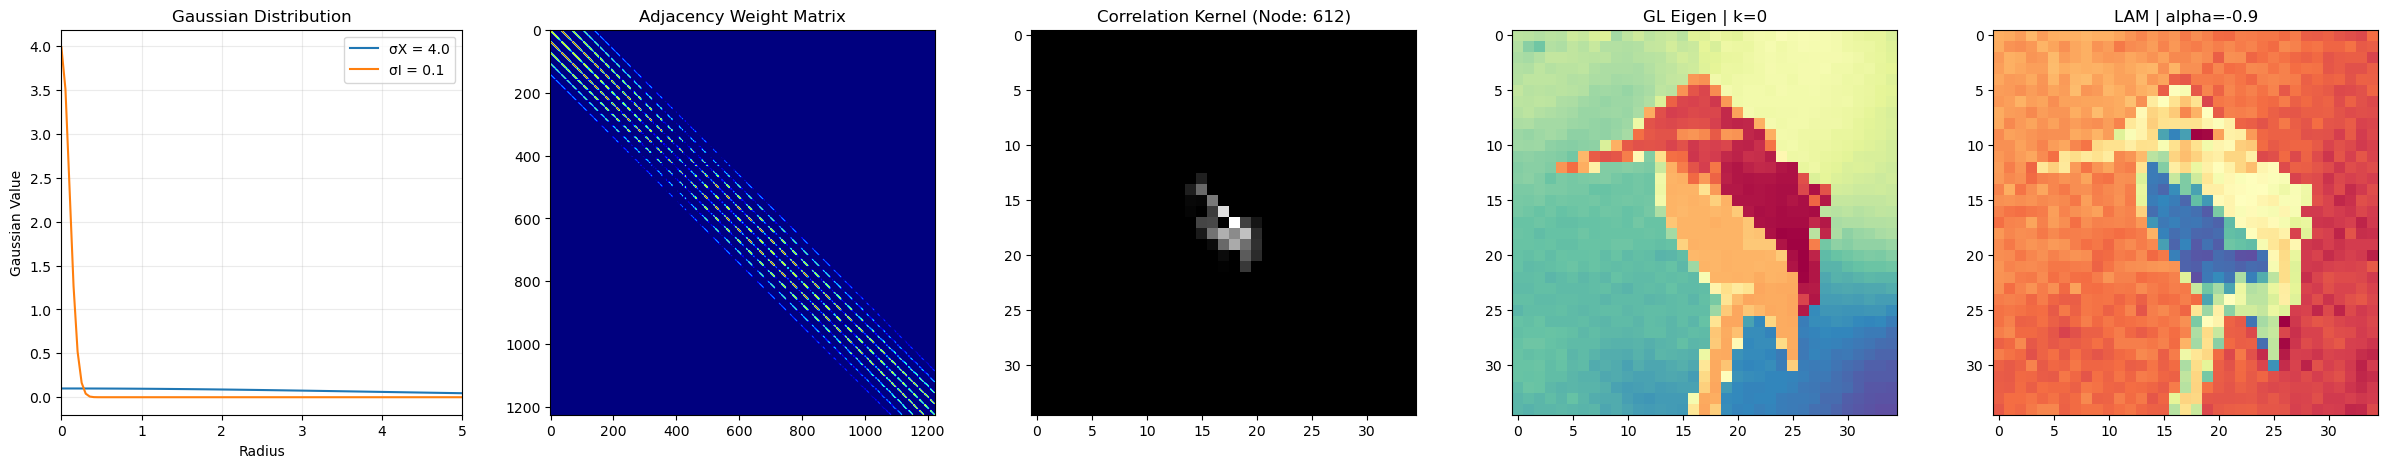

In [11]:
plt.figure(figsize=(30,5))
plt.subplot(1, 5, 1)
plt.plot(dist, libtools.gaussian(dist, sigmaX), label=f'σX = {sigmaX}')
plt.plot(dist, libtools.gaussian(dist, sigmaI), label=f'σI = {sigmaI}')
plt.title('Gaussian Distribution')
plt.xlabel('Radius'), plt.ylabel('Gaussian Value')
plt.xlim([0, rad]), plt.grid(alpha=0.25), plt.legend()

plt.subplot(1, 5, 2)
plt.imshow(W, 'jet')
plt.title('Adjacency Weight Matrix')

plt.subplot(1, 5, 3)
plt.imshow(W[start_node].reshape(src.shape[0], src.shape[1]), 'gray') 
plt.title('Correlation Kernel (Node: ' + str(start_node) + ')')

plt.subplot(1, 5, 4)
k = 0
plt.imshow(v[:,k].reshape(src.shape[0], src.shape[1]), 'Spectral', vmin=np.min(v[:,k]), vmax=np.max(v[:,k]))
plt.title('GL Eigen | k='+ str(k))

plt.subplot(1, 5, 5)
plt.imshow(m.reshape(src.shape[0], src.shape[1]), 'Spectral', vmin=np.min(m), vmax=np.max(m))
plt.title('LAM | alpha=' + str(alpha))

---

#### LOAD SOM

In [12]:
# SOM ORIENTATION MATRIX
src = np.load('../data/mat/SOM_orient_v1.npy')
src = libtools.downsample(src, 4)

(51, 51)
Theta θ | min: 0.0012 max: 6.282


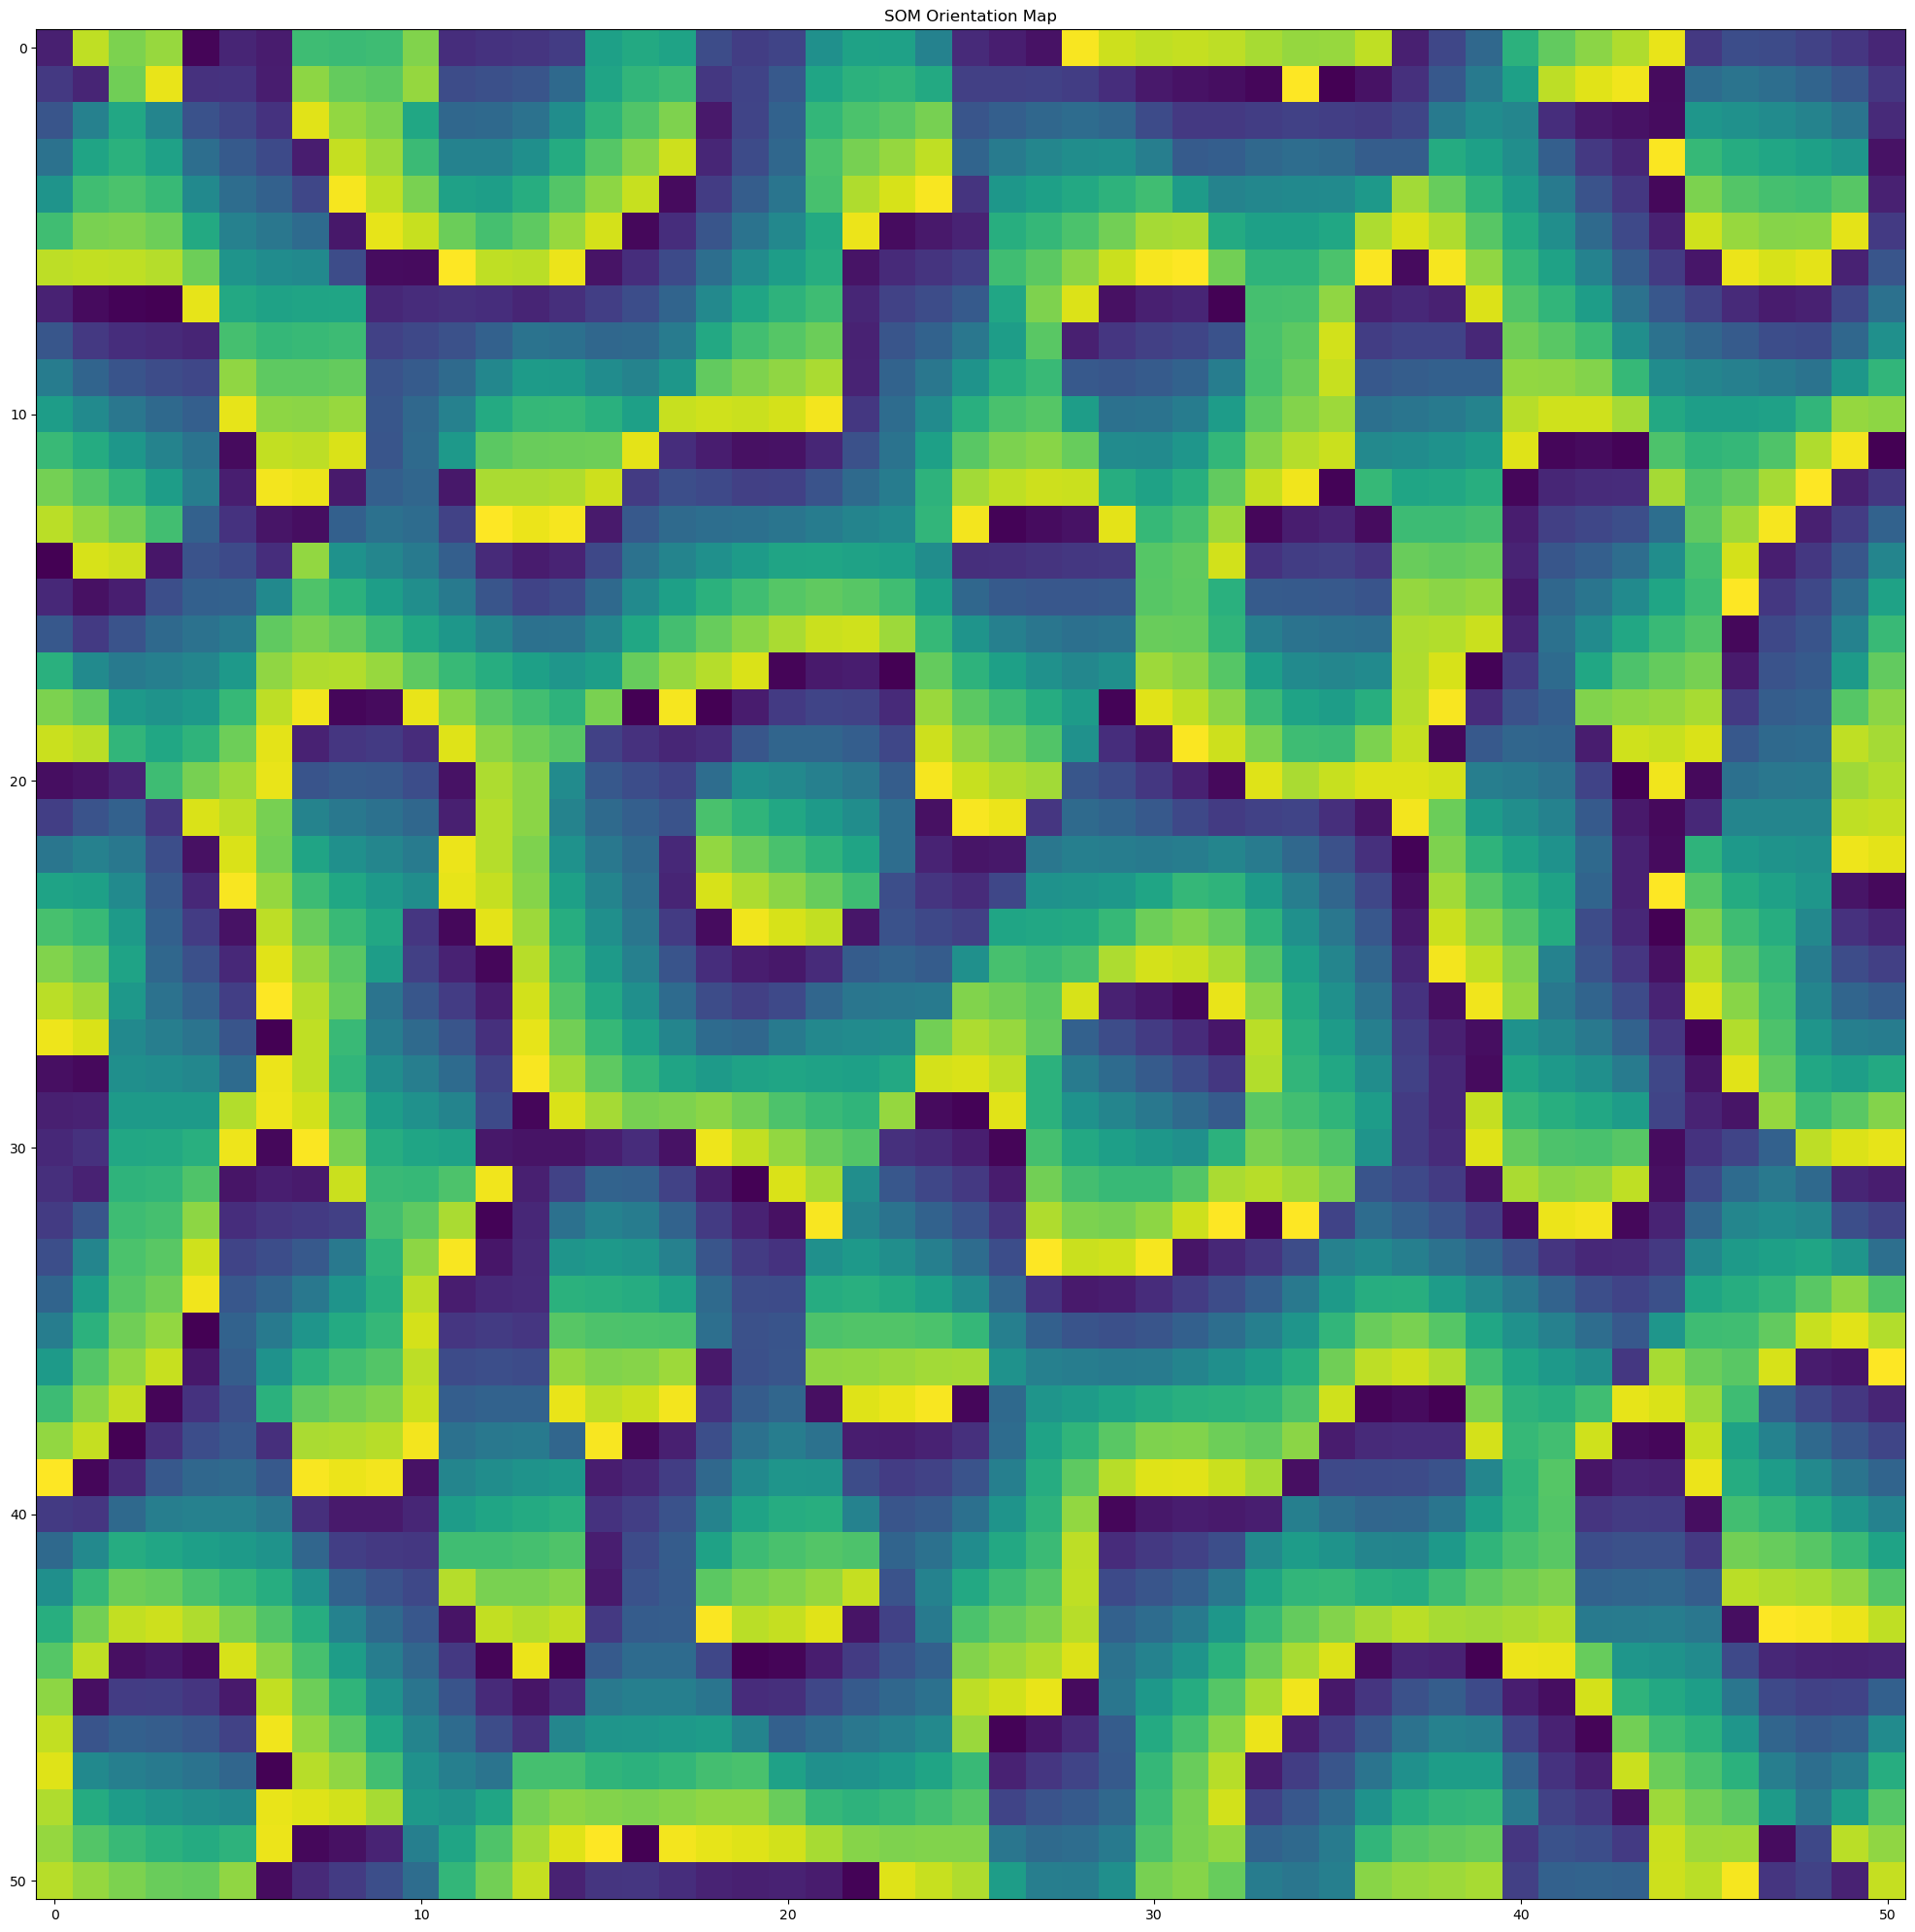

In [13]:
plt.figure(figsize=(20,20))
plt.imshow(src)
plt.title('SOM Orientation Map')
plt.tight_layout()

print(src.shape)
print('Theta θ | min:', round(src.min(),4), 'max:', round(src.max(),4))

---

### SigmaX | Spatial Domain

In [14]:
P = src.shape[0] * src.shape[1]
start_node = int(int(src.shape[0]/2) * src.shape[1] + int(src.shape[0]/2))
print('Start node:', start_node)

Start node: 1300


In [15]:
sigmaX = np.array([0.1, 1, 4, 10]).astype(float)
sigmaA = 1.0

In [16]:
Wx, Vx, Mx = [],[],[]
ticker = len(sigmaX)

for i in tqdm(range(ticker)):
    W = libtools.construct_SOAM(src, rad, sigmaX[i], sigmaA)

    _, v = libtools.GL_eigen(W, 'asym')

    graph = LAM(N, P, prob, W, gamma, "asym")
    alpha = -0.9; graph._set_weight(alpha)
    m_log, obj_log = graph.simulate_single(alpha, eta, epochs, start_node)
    m = m_log[-1,:]

    Wx.append(W)
    Vx.append(v)
    Mx.append(m)

100%|██████████| 4/4 [03:19<00:00, 49.99s/it]


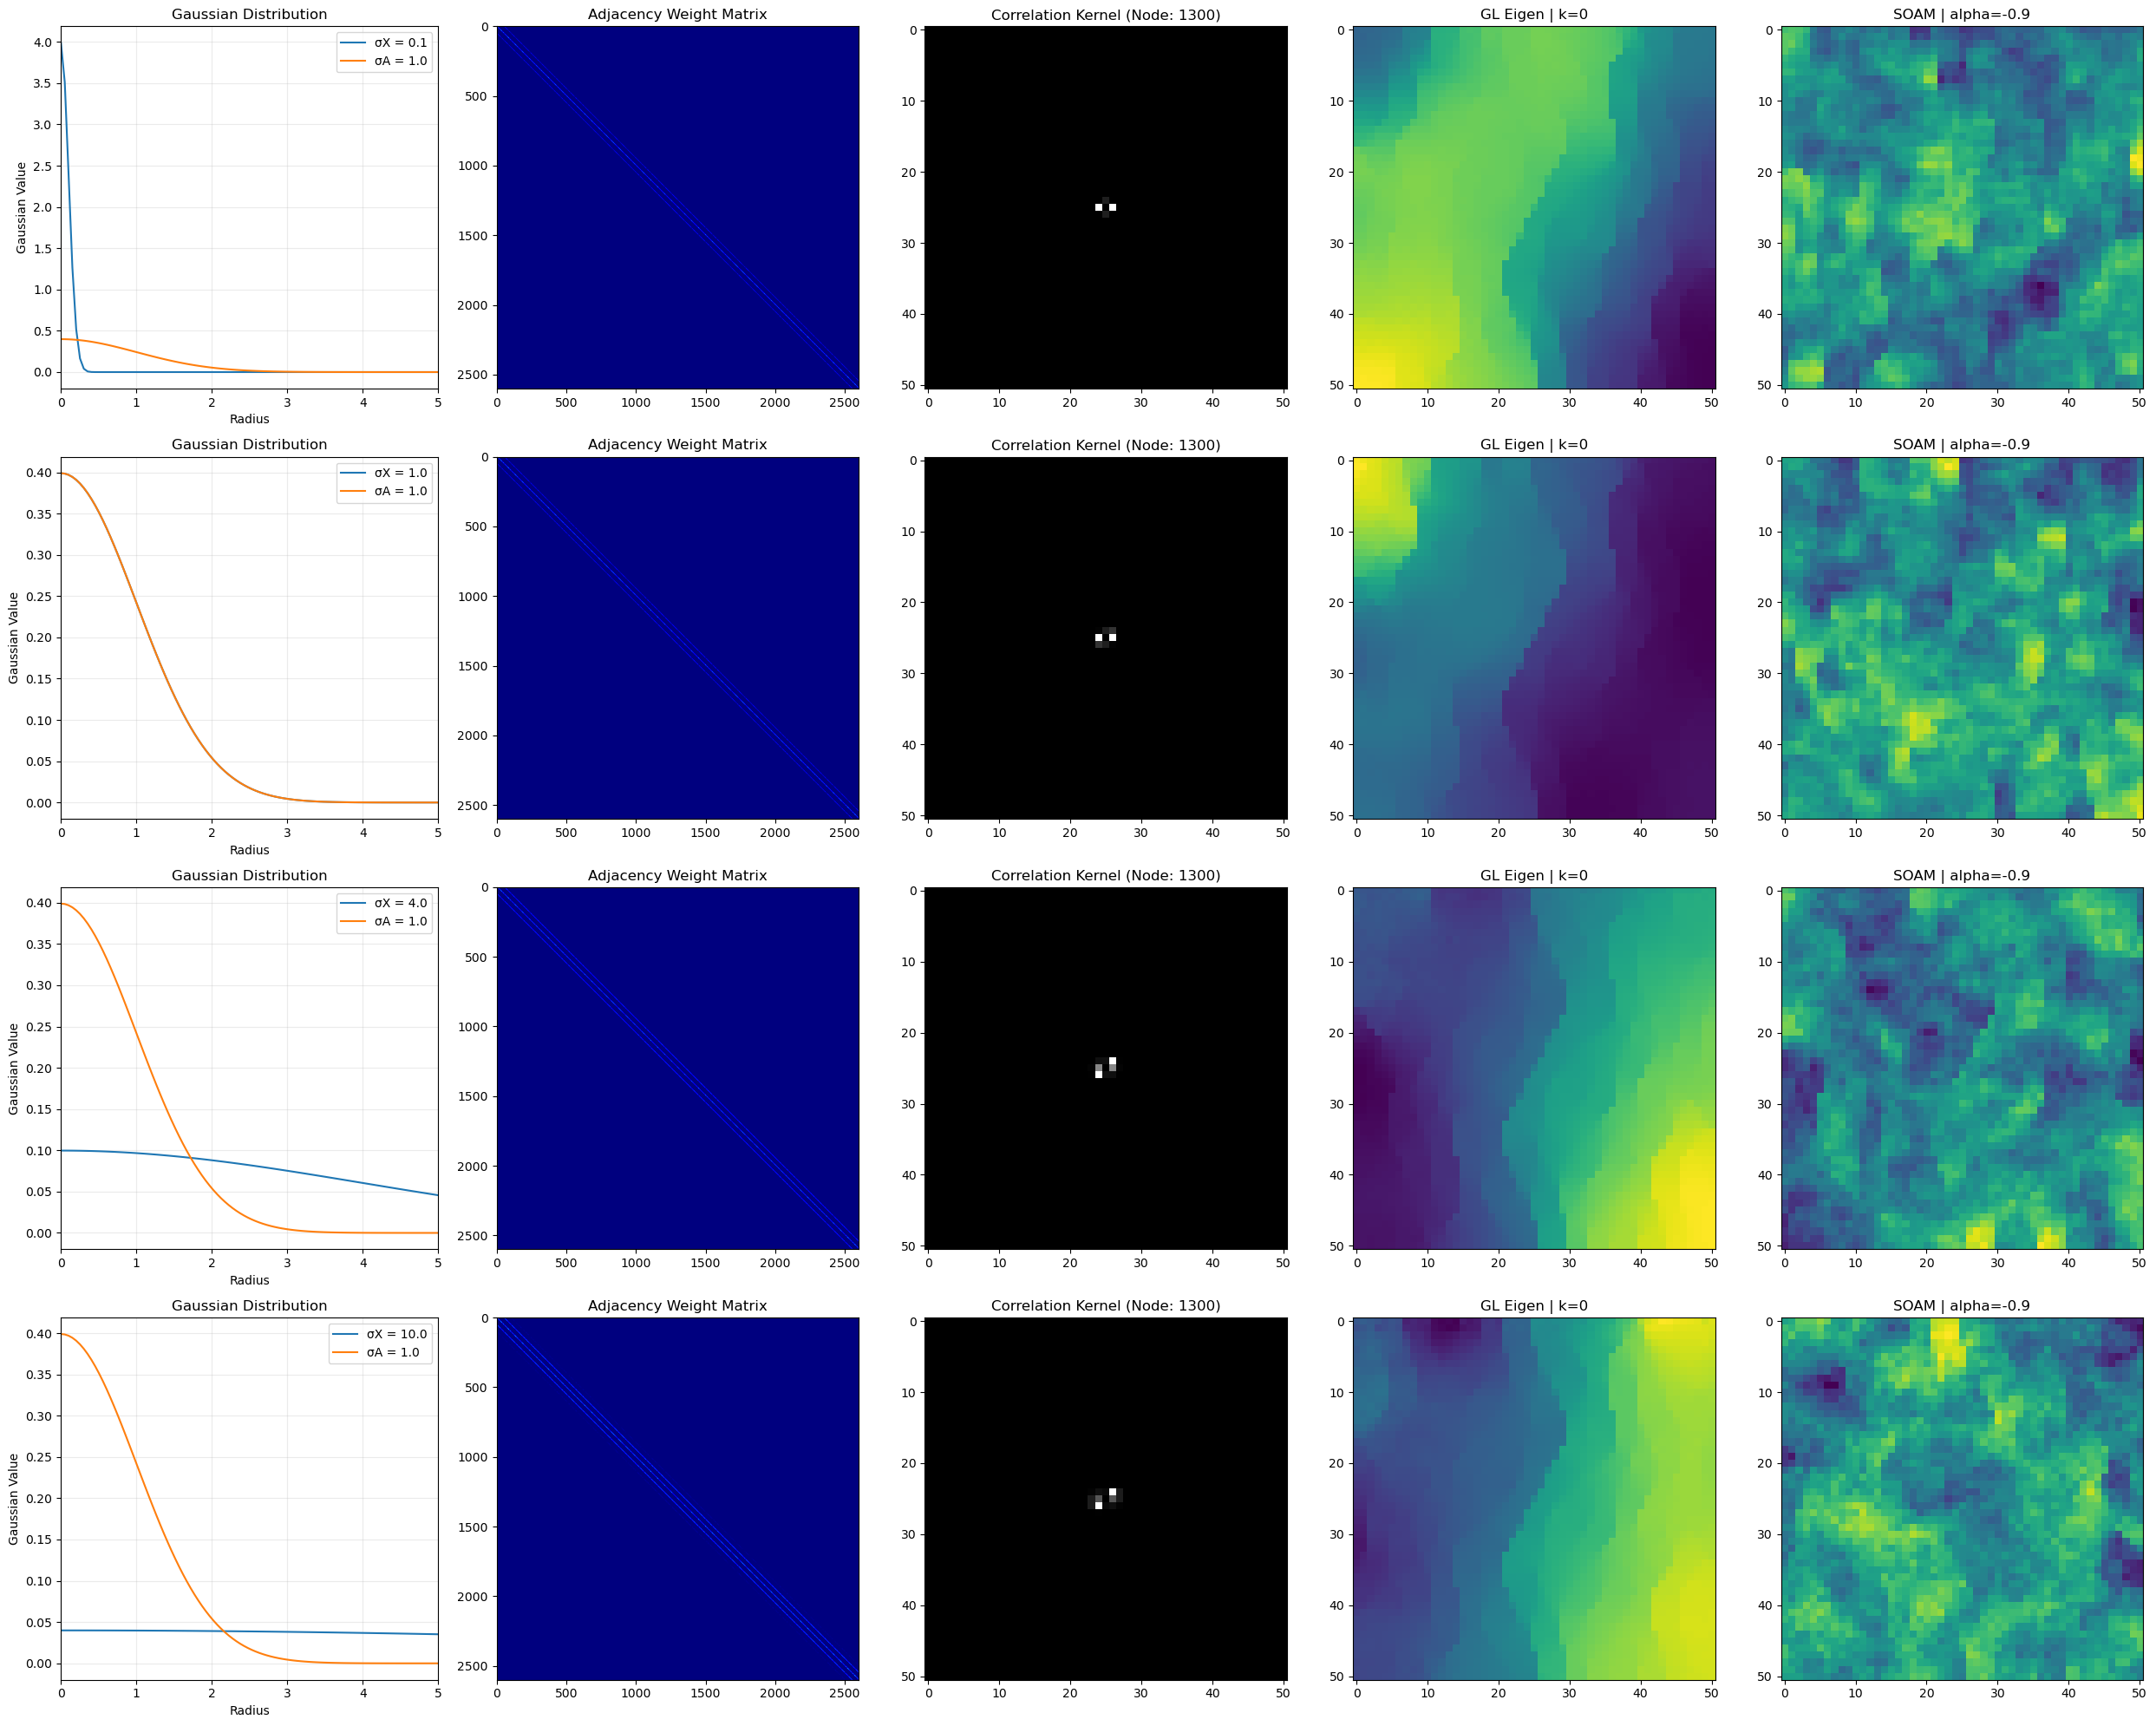

In [17]:
plt.figure(figsize=(25,5*ticker))
for i in range(ticker):
    plt.subplot(ticker, 5, i * 5 + 1)
    plt.plot(dist, libtools.gaussian(dist, sigmaX[i]), label=f'σX = {sigmaX[i]}')
    plt.plot(dist, libtools.gaussian(dist, sigmaA), label=f'σA = {sigmaA}')
    plt.title('Gaussian Distribution')
    plt.xlabel('Radius'), plt.ylabel('Gaussian Value')
    plt.xlim([0, rad]), plt.grid(alpha=0.25), plt.legend()

    plt.subplot(ticker, 5, i * 5 + 2)
    plt.imshow(Wx[i], 'jet')
    plt.title('Adjacency Weight Matrix')

    plt.subplot(ticker, 5, i * 5 + 3)
    plt.imshow(Wx[i][start_node].reshape(src.shape), 'gray')
    plt.title('Correlation Kernel (Node: ' + str(start_node) + ')')

    plt.subplot(ticker, 5, i * 5 + 4)
    k = 0
    plt.imshow(Vx[i][:,k].reshape(src.shape), vmin=np.min(Vx[i][:,k]), vmax=np.max(Vx[i][:,k]))
    plt.title('GL Eigen | k='+ str(k))

    plt.subplot(ticker, 5, i * 5 + 5)
    plt.imshow(Mx[i].reshape(src.shape), vmin=np.min(Mx[i]), vmax=np.max(Mx[i]))
    plt.title('SOAM | alpha=' + str(alpha)), plt.tight_layout()

plt.tight_layout()

---
### SigmaA | Angular Component

In [18]:
sigmaX = 1.0
sigmaA = np.array([0.1, 1, 4, 10]).astype(float)

In [19]:
Wa, Va, Ma = [],[],[]
ticker = len(sigmaA)

for i in tqdm(range(ticker)):
    W = libtools.construct_SOAM(src, rad, sigmaX, sigmaA[i])

    _, v = libtools.GL_eigen(W, 'asym')

    graph = LAM(N, P, prob, W, gamma, "asym")
    alpha = -0.9; graph._set_weight(alpha)
    m_log, obj_log = graph.simulate_single(alpha, eta, epochs, start_node)
    m = m_log[-1,:]

    Wa.append(W)
    Va.append(v)
    Ma.append(m)

100%|██████████| 4/4 [03:25<00:00, 51.25s/it]


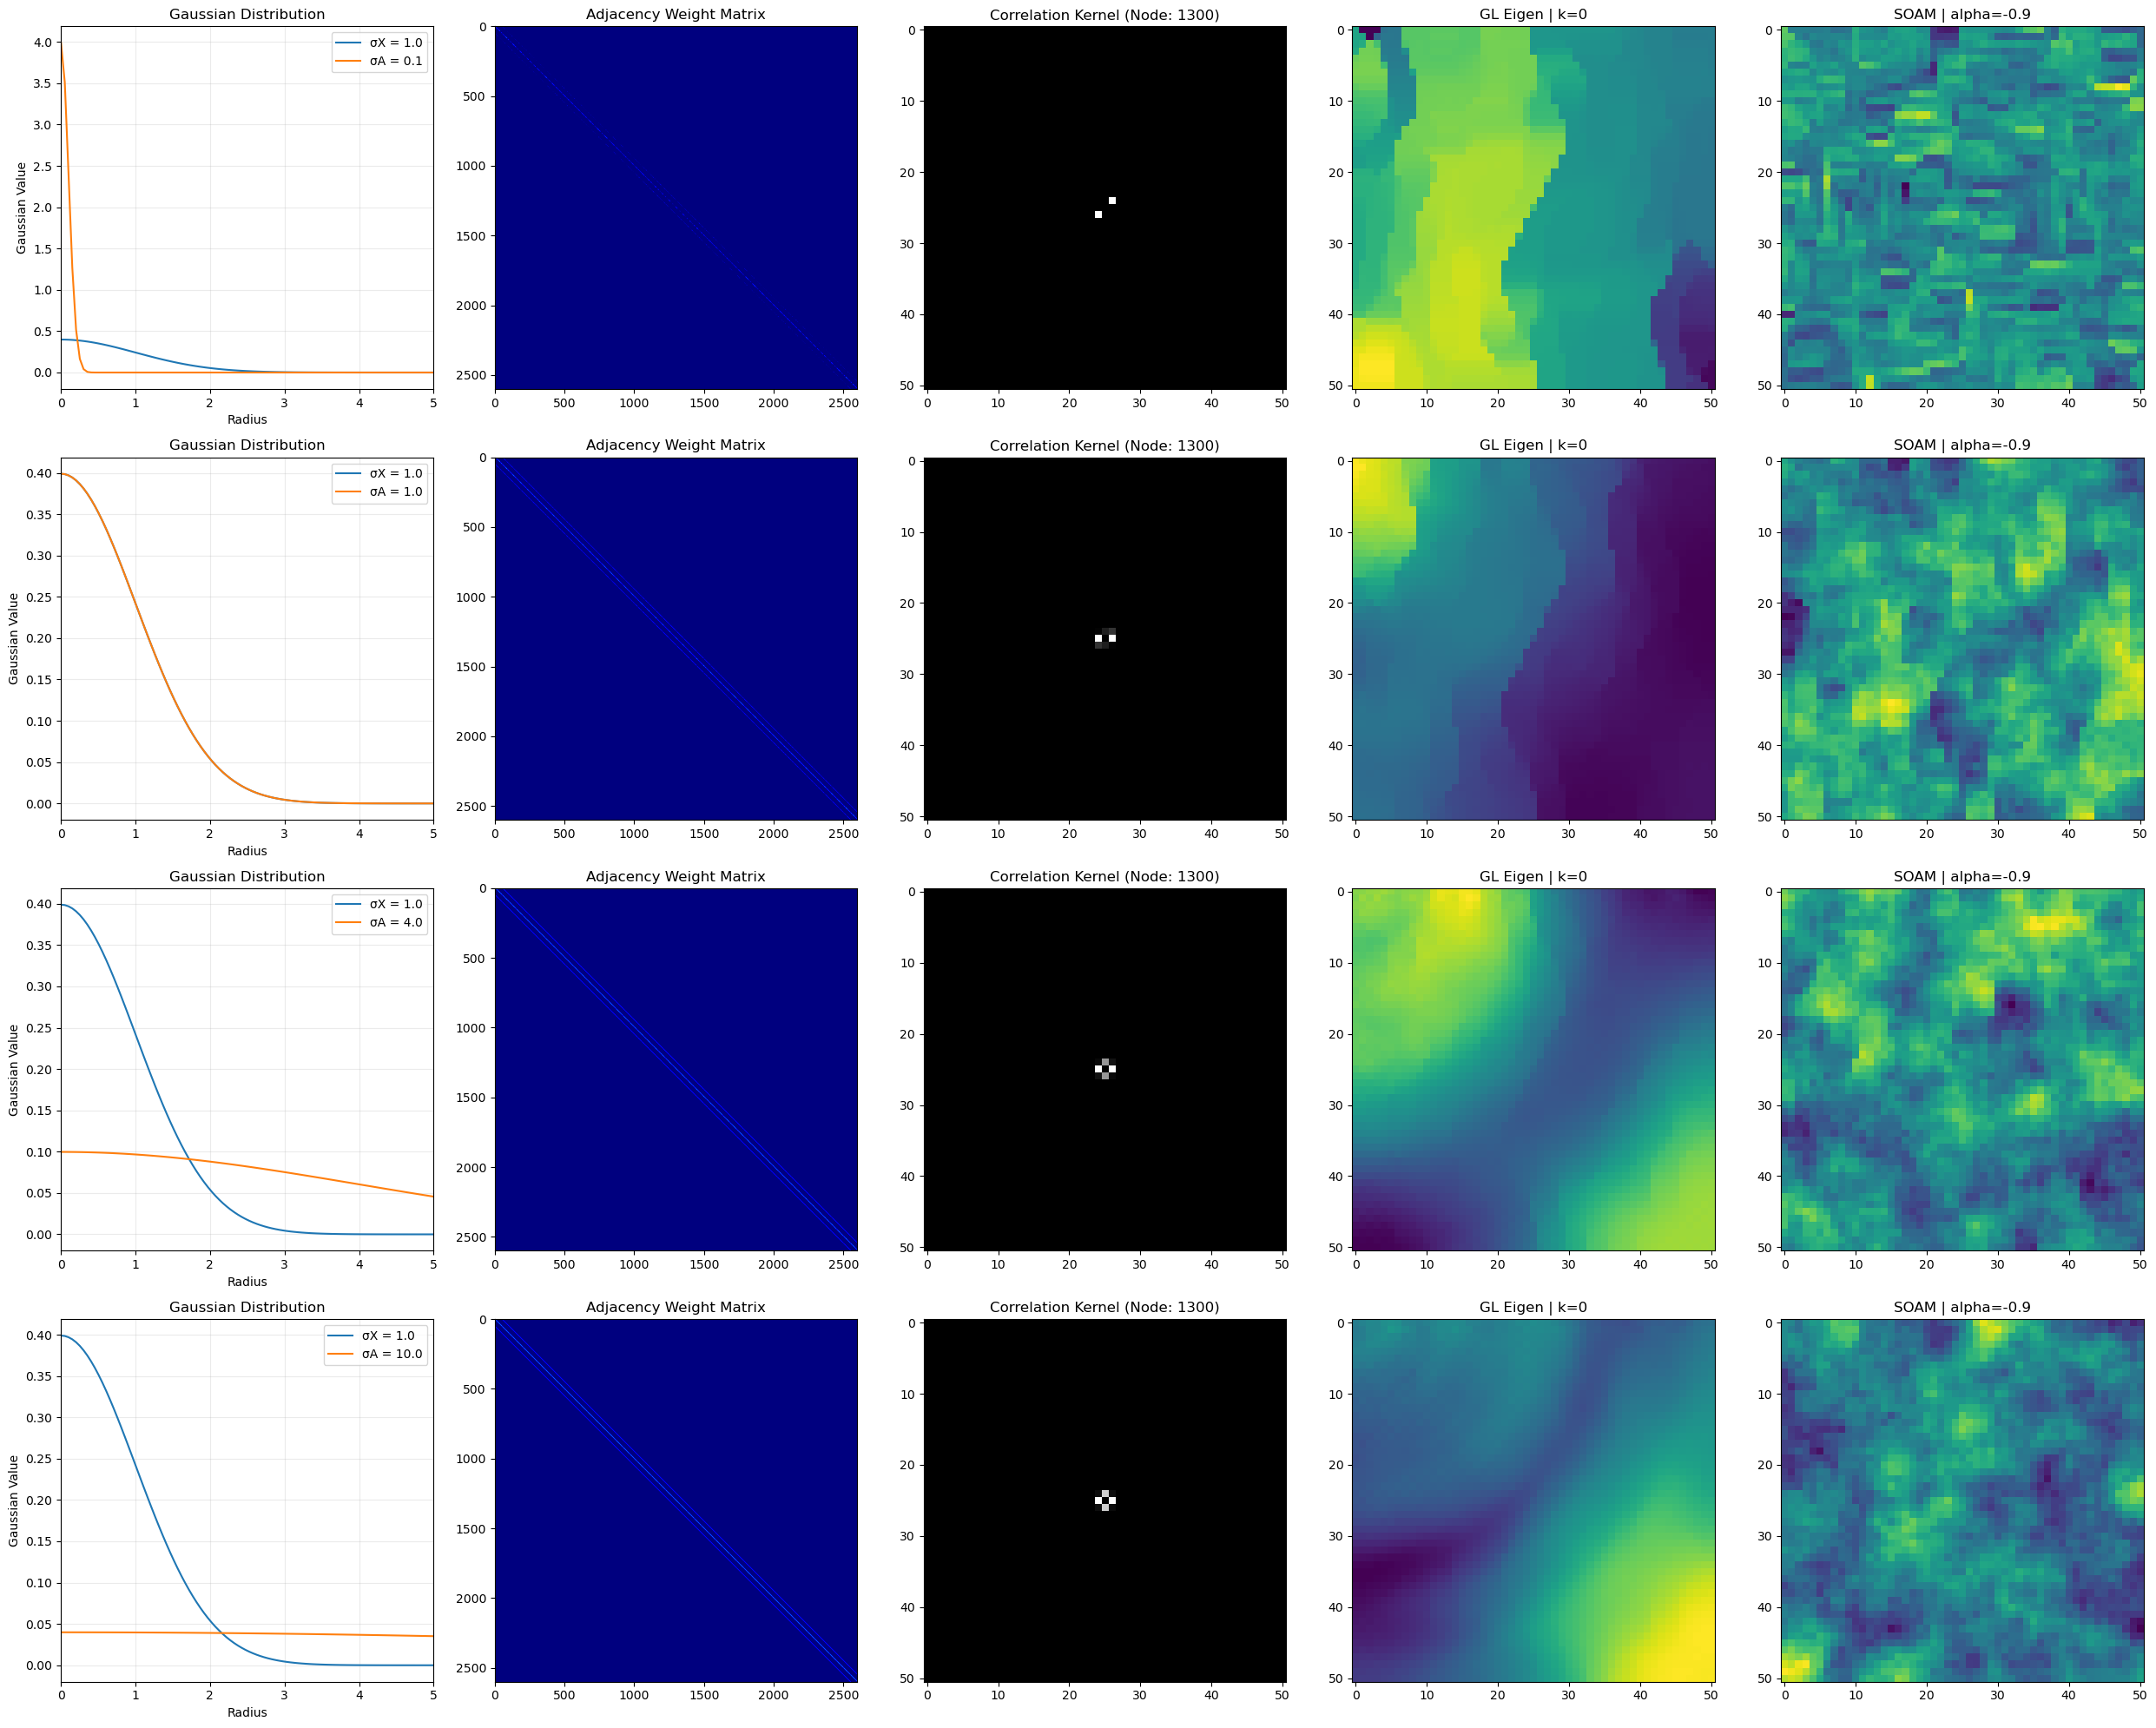

In [20]:
plt.figure(figsize=(25,5*ticker))
for i in range(ticker):
    plt.subplot(ticker, 5, i * 5 + 1)
    plt.plot(dist, libtools.gaussian(dist, sigmaX), label=f'σX = {sigmaX}')
    plt.plot(dist, libtools.gaussian(dist, sigmaA[i]), label=f'σA = {sigmaA[i]}')
    plt.title('Gaussian Distribution')
    plt.xlabel('Radius'), plt.ylabel('Gaussian Value')
    plt.xlim([0, rad]), plt.grid(alpha=0.25), plt.legend()

    plt.subplot(ticker, 5, i * 5 + 2)
    plt.imshow(Wa[i], 'jet')
    plt.title('Adjacency Weight Matrix')

    plt.subplot(ticker, 5, i * 5 + 3)
    plt.imshow(Wa[i][start_node].reshape(src.shape), 'gray')
    plt.title('Correlation Kernel (Node: ' + str(start_node) + ')')

    plt.subplot(ticker, 5, i * 5 + 4)
    k = 0
    plt.imshow(Va[i][:,k].reshape(src.shape), vmin=np.min(Va[i][:,k]), vmax=np.max(Va[i][:,k]))
    plt.title('GL Eigen | k='+ str(k))

    plt.subplot(ticker, 5, i * 5 + 5)
    plt.imshow(Ma[i].reshape(src.shape), vmin=np.min(Ma[i]), vmax=np.max(Ma[i]))
    plt.title('SOAM | alpha=' + str(alpha))

plt.tight_layout()

---

### SOAM | FINE-TUNING

In [21]:
sigmaX = 4.0
sigmaA = 1.0

W = libtools.construct_SOAM(src, rad, sigmaX, sigmaA)

_, v = libtools.GL_eigen(W, 'asym')

graph = LAM(N, P, prob, W, gamma, "asym")
alpha = -0.9; graph._set_weight(alpha)
m_log, obj_log = graph.simulate_single(alpha, eta, epochs, start_node)
m = m_log[-1,:]

Text(0.5, 1.0, 'SOAM | alpha=-0.9')

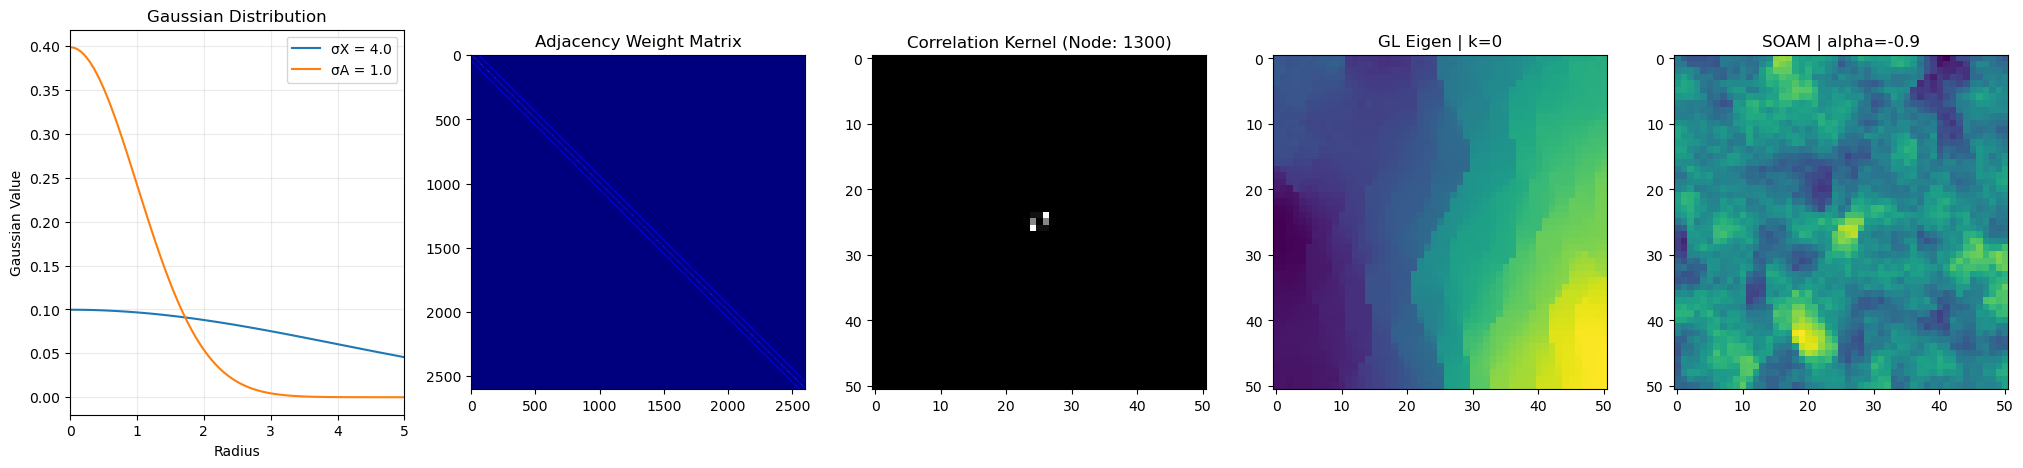

In [22]:
plt.figure(figsize=(25,5))
plt.subplot(1, 5, 1)
plt.plot(dist, libtools.gaussian(dist, sigmaX), label=f'σX = {sigmaX}')
plt.plot(dist, libtools.gaussian(dist, sigmaA), label=f'σA = {sigmaA}')
plt.title('Gaussian Distribution')
plt.xlabel('Radius'), plt.ylabel('Gaussian Value')
plt.xlim([0, rad]), plt.grid(alpha=0.25), plt.legend()

plt.subplot(1, 5, 2)
plt.imshow(W, 'jet')
plt.title('Adjacency Weight Matrix')

plt.subplot(1, 5, 3)
plt.imshow(W[start_node].reshape(src.shape), 'gray')
plt.title('Correlation Kernel (Node: ' + str(start_node) + ')')

plt.subplot(1, 5, 4)
k = 0
plt.imshow(v[:,k].reshape(src.shape), vmin=np.min(v[:,k]), vmax=np.max(v[:,k]))
plt.title('GL Eigen | k='+ str(k))

plt.subplot(1, 5, 5)
plt.imshow(m.reshape(src.shape), vmin=np.min(m), vmax=np.max(m))
plt.title('SOAM | alpha=' + str(alpha))